## Useful Modules

In [34]:
import torch
import torchvision
import torchvision.transforms as transforms

import time
from tqdm import tqdm

from matplotlib import pyplot as plt
from models import lnn, cnn, resnet

%load_ext autoreload
%autoreload 2

In [2]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]
)

## Training and Testing Utils

In [3]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=10, device='cpu', model_name='model', dataset_name='dataset'):
    model.to(device)

    train_loss_history = []
    train_accuracy_history = []
    
    valid_loss_history = []
    valid_accuracy_history = []
    
    best_iter = 0
    best_valid_loss = float('inf')
    best_valid_accuracy = 0.0
    best_model = None

    start_time = time.time()

    for epoch in range(epochs):
        model.train()

        train_loss, train_corrects = 0.0, 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

            predicted = outputs.argmax(dim=1)
            train_corrects += (predicted == labels).sum().item()
    
        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = train_corrects / len(train_loader.dataset)

        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)
        
        model.eval()
        
        valid_loss, valid_corrects = 0.0, 0
        
        with torch.no_grad():
            for inputs, labels in tqdm(valid_loader, desc=f'Epoch {epoch+1}/{epochs}'):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                valid_loss += loss.item() * inputs.size(0)

                predicted = outputs.argmax(dim=1)
                valid_corrects += (predicted == labels).sum().item()
        
        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_accuracy = valid_corrects / len(valid_loader.dataset)
        
        if valid_accuracy > best_valid_accuracy:
            best_iter = epoch + 1
            best_valid_loss = valid_loss
            best_valid_accuracy = valid_accuracy
            best_model = model.state_dict()
        
        valid_loss_history.append(valid_loss)
        valid_accuracy_history.append(valid_accuracy)
        
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}')
    
    end_time = time.time()

    print(f'Total training time: {end_time - start_time:.2f} seconds.')
    
    torch.save(best_model, f'weights/{dataset_name}_{model_name}_best.pth')
    
    print(f'Best model at epoch {best_iter} with valid loss: {best_valid_loss:.4f}, valid accuracy: {best_valid_accuracy:.4f}')
    
    torch.save(model.state_dict(), f'weights/{dataset_name}_{model_name}_last.pth')

    return train_loss_history, train_accuracy_history, valid_loss_history, valid_accuracy_history

In [4]:
def test_model(model, test_loader, criterion, device='cpu'):
    model.to(device)
    model.eval()
    
    test_loss, test_corrects = 0.0, 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item() * inputs.size(0)
            
            predicted = outputs.argmax(dim=1)
            test_corrects += (predicted == labels).sum().item()
        
    test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = test_corrects / len(test_loader.dataset)
    
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}%')
    
    return test_loss, test_accuracy

## MNIST Digit Classification

In [5]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_set, valid_set = torch.utils.data.random_split(train_dataset, [50000, 10000])
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [6]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

### Linear Neural Network

In [7]:
lnn_model = lnn.LNN(28 * 28, num_classes=10)

num_params = sum([p.numel() for p in lnn_model.parameters()])
print("Number of parameters: ", num_params)

Number of parameters:  15501322


In [8]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lnn_model.parameters(), lr=0.00001)

train_loss_history, train_accuracy_history, valid_loss_history, valid_accuracy_history = train_model(lnn_model, train_loader, valid_loader, criterion, optimizer, epochs=30, device='cuda', model_name='lnn', dataset_name='mnist')

Epoch 1/30: 100%|██████████| 157/157 [00:00<00:00, 312.58it/s]


Train Loss: 0.7453, Train Accuracy: 0.8074
Valid Loss: 0.3487, Valid Accuracy: 0.8968


Epoch 2/30: 100%|██████████| 157/157 [00:00<00:00, 311.54it/s]


Train Loss: 0.3142, Train Accuracy: 0.9078
Valid Loss: 0.2842, Valid Accuracy: 0.9176


Epoch 3/30: 100%|██████████| 157/157 [00:00<00:00, 301.69it/s]


Train Loss: 0.2562, Train Accuracy: 0.9244
Valid Loss: 0.2307, Valid Accuracy: 0.9300


Epoch 4/30: 100%|██████████| 157/157 [00:00<00:00, 292.22it/s]


Train Loss: 0.2157, Train Accuracy: 0.9371
Valid Loss: 0.2007, Valid Accuracy: 0.9395


Epoch 5/30: 100%|██████████| 157/157 [00:00<00:00, 321.15it/s]


Train Loss: 0.1850, Train Accuracy: 0.9456
Valid Loss: 0.1740, Valid Accuracy: 0.9479


Epoch 6/30: 100%|██████████| 157/157 [00:00<00:00, 291.29it/s]


Train Loss: 0.1622, Train Accuracy: 0.9518
Valid Loss: 0.1548, Valid Accuracy: 0.9525


Epoch 7/30: 100%|██████████| 157/157 [00:00<00:00, 300.45it/s]


Train Loss: 0.1429, Train Accuracy: 0.9577
Valid Loss: 0.1419, Valid Accuracy: 0.9558


Epoch 8/30: 100%|██████████| 157/157 [00:00<00:00, 299.76it/s]


Train Loss: 0.1272, Train Accuracy: 0.9629
Valid Loss: 0.1395, Valid Accuracy: 0.9578


Epoch 9/30: 100%|██████████| 157/157 [00:00<00:00, 305.90it/s]


Train Loss: 0.1134, Train Accuracy: 0.9663
Valid Loss: 0.1187, Valid Accuracy: 0.9648


Epoch 10/30: 100%|██████████| 157/157 [00:00<00:00, 289.78it/s]


Train Loss: 0.1028, Train Accuracy: 0.9694
Valid Loss: 0.1161, Valid Accuracy: 0.9647


Epoch 11/30: 100%|██████████| 157/157 [00:00<00:00, 300.55it/s]


Train Loss: 0.0920, Train Accuracy: 0.9731
Valid Loss: 0.1004, Valid Accuracy: 0.9687


Epoch 12/30: 100%|██████████| 157/157 [00:00<00:00, 175.21it/s]


Train Loss: 0.0839, Train Accuracy: 0.9752
Valid Loss: 0.1009, Valid Accuracy: 0.9676


Epoch 13/30: 100%|██████████| 157/157 [00:00<00:00, 284.63it/s]


Train Loss: 0.0766, Train Accuracy: 0.9772
Valid Loss: 0.0978, Valid Accuracy: 0.9694


Epoch 14/30: 100%|██████████| 157/157 [00:00<00:00, 280.33it/s]


Train Loss: 0.0693, Train Accuracy: 0.9801
Valid Loss: 0.0891, Valid Accuracy: 0.9717


Epoch 15/30: 100%|██████████| 157/157 [00:00<00:00, 294.70it/s]


Train Loss: 0.0635, Train Accuracy: 0.9810
Valid Loss: 0.0824, Valid Accuracy: 0.9735


Epoch 16/30: 100%|██████████| 157/157 [00:00<00:00, 296.54it/s]


Train Loss: 0.0567, Train Accuracy: 0.9839
Valid Loss: 0.0807, Valid Accuracy: 0.9753


Epoch 17/30: 100%|██████████| 157/157 [00:00<00:00, 296.52it/s]


Train Loss: 0.0531, Train Accuracy: 0.9842
Valid Loss: 0.0771, Valid Accuracy: 0.9767


Epoch 18/30: 100%|██████████| 157/157 [00:00<00:00, 299.75it/s]


Train Loss: 0.0476, Train Accuracy: 0.9857
Valid Loss: 0.0784, Valid Accuracy: 0.9763


Epoch 19/30: 100%|██████████| 157/157 [00:00<00:00, 304.66it/s]


Train Loss: 0.0426, Train Accuracy: 0.9876
Valid Loss: 0.0695, Valid Accuracy: 0.9787


Epoch 20/30: 100%|██████████| 157/157 [00:00<00:00, 321.39it/s]


Train Loss: 0.0385, Train Accuracy: 0.9889
Valid Loss: 0.0784, Valid Accuracy: 0.9768


Epoch 21/30: 100%|██████████| 157/157 [00:00<00:00, 276.24it/s]


Train Loss: 0.0355, Train Accuracy: 0.9897
Valid Loss: 0.0697, Valid Accuracy: 0.9794


Epoch 22/30: 100%|██████████| 157/157 [00:00<00:00, 299.66it/s]


Train Loss: 0.0312, Train Accuracy: 0.9910
Valid Loss: 0.0734, Valid Accuracy: 0.9773


Epoch 23/30: 100%|██████████| 157/157 [00:00<00:00, 302.62it/s]


Train Loss: 0.0280, Train Accuracy: 0.9924
Valid Loss: 0.0689, Valid Accuracy: 0.9786


Epoch 24/30: 100%|██████████| 157/157 [00:00<00:00, 276.91it/s]


Train Loss: 0.0269, Train Accuracy: 0.9926
Valid Loss: 0.0734, Valid Accuracy: 0.9780


Epoch 25/30: 100%|██████████| 157/157 [00:00<00:00, 301.36it/s]


Train Loss: 0.0229, Train Accuracy: 0.9939
Valid Loss: 0.0659, Valid Accuracy: 0.9805


Epoch 26/30: 100%|██████████| 157/157 [00:00<00:00, 302.10it/s]


Train Loss: 0.0203, Train Accuracy: 0.9950
Valid Loss: 0.0702, Valid Accuracy: 0.9788


Epoch 27/30: 100%|██████████| 157/157 [00:00<00:00, 296.96it/s]


Train Loss: 0.0187, Train Accuracy: 0.9948
Valid Loss: 0.0707, Valid Accuracy: 0.9784


Epoch 28/30: 100%|██████████| 157/157 [00:00<00:00, 308.91it/s]


Train Loss: 0.0162, Train Accuracy: 0.9960
Valid Loss: 0.0745, Valid Accuracy: 0.9778


Epoch 29/30: 100%|██████████| 157/157 [00:00<00:00, 313.72it/s]


Train Loss: 0.0139, Train Accuracy: 0.9968
Valid Loss: 0.0775, Valid Accuracy: 0.9777


Epoch 30/30: 100%|██████████| 157/157 [00:00<00:00, 305.06it/s]


Train Loss: 0.0131, Train Accuracy: 0.9968
Valid Loss: 0.0688, Valid Accuracy: 0.9796
Total training time: 192.22 seconds.
Best model at epoch 25 with valid loss: 0.0659, valid accuracy: 0.9805


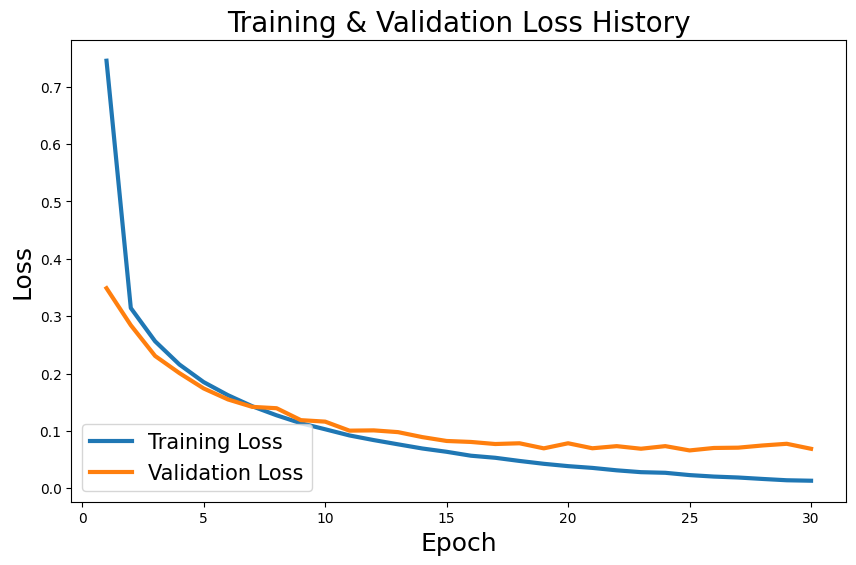

In [9]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Training Loss', linewidth=3)
plt.plot(range(1, len(valid_loss_history) + 1), valid_loss_history, label='Validation Loss', linewidth=3)

plt.title('Training & Validation Loss History', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(loc='lower left', fontsize=15)

plt.savefig('figures/mnist_lnn_loss_history.pdf', format='pdf', bbox_inches='tight')

plt.show();

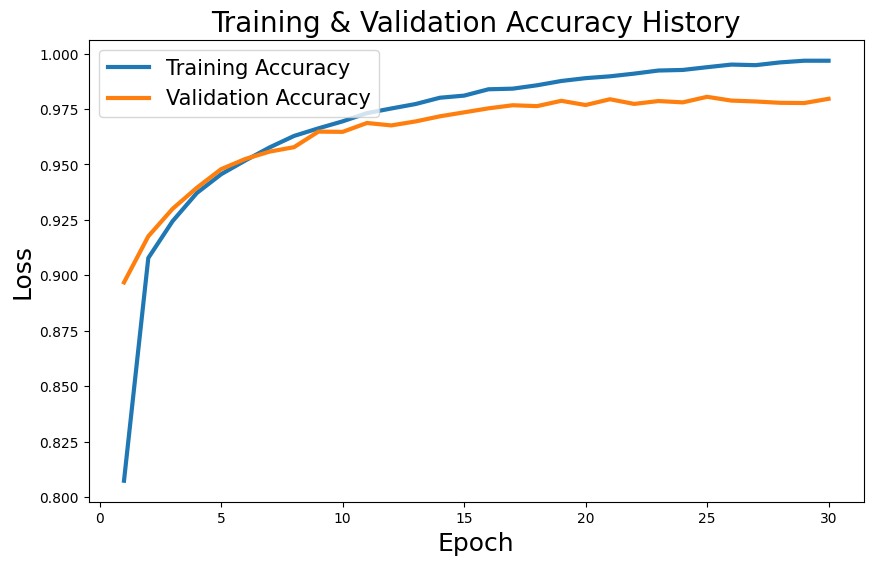

In [10]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_accuracy_history) + 1), train_accuracy_history, label='Training Accuracy', linewidth=3)
plt.plot(range(1, len(valid_accuracy_history) + 1), valid_accuracy_history, label='Validation Accuracy', linewidth=3)

plt.title('Training & Validation Accuracy History', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(loc='upper left', fontsize=15)

plt.savefig('figures/mnist_lnn_accuracy_history.pdf', format='pdf', bbox_inches='tight')

plt.show();

In [11]:
test_loss, test_accuracy = test_model(lnn_model, test_loader, criterion, device='cuda')

Test Loss: 0.0760, Test Accuracy: 0.9780%


### Convolutional Neural Network

In [12]:
cnn_model = cnn.CNN(1, num_classes=10, input_size=28)

num_params = sum([p.numel() for p in cnn_model.parameters()])
print("Number of parameters: ", num_params)

Number of parameters:  659250


In [13]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.00001)

train_loss_history, train_accuracy_history, valid_loss_history, valid_accuracy_history = train_model(cnn_model, train_loader, valid_loader, criterion, optimizer, epochs=20, device='cuda', model_name='cnn', dataset_name='mnist')

Epoch 1/20:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1/20: 100%|██████████| 157/157 [00:00<00:00, 270.14it/s]


Train Loss: 1.0319, Train Accuracy: 0.8103
Valid Loss: 0.3348, Valid Accuracy: 0.9336


Epoch 2/20: 100%|██████████| 157/157 [00:00<00:00, 296.93it/s]


Train Loss: 0.2289, Train Accuracy: 0.9477
Valid Loss: 0.1620, Valid Accuracy: 0.9588


Epoch 3/20: 100%|██████████| 157/157 [00:00<00:00, 294.70it/s]


Train Loss: 0.1368, Train Accuracy: 0.9640
Valid Loss: 0.1149, Valid Accuracy: 0.9688


Epoch 4/20: 100%|██████████| 157/157 [00:00<00:00, 290.49it/s]


Train Loss: 0.1004, Train Accuracy: 0.9726
Valid Loss: 0.0913, Valid Accuracy: 0.9742


Epoch 5/20: 100%|██████████| 157/157 [00:00<00:00, 288.83it/s]


Train Loss: 0.0801, Train Accuracy: 0.9774
Valid Loss: 0.0761, Valid Accuracy: 0.9773


Epoch 6/20: 100%|██████████| 157/157 [00:00<00:00, 299.33it/s]


Train Loss: 0.0670, Train Accuracy: 0.9815
Valid Loss: 0.0677, Valid Accuracy: 0.9803


Epoch 7/20: 100%|██████████| 157/157 [00:00<00:00, 296.02it/s]


Train Loss: 0.0576, Train Accuracy: 0.9841
Valid Loss: 0.0607, Valid Accuracy: 0.9814


Epoch 8/20: 100%|██████████| 157/157 [00:00<00:00, 292.35it/s]


Train Loss: 0.0500, Train Accuracy: 0.9859
Valid Loss: 0.0555, Valid Accuracy: 0.9827


Epoch 9/20: 100%|██████████| 157/157 [00:00<00:00, 297.87it/s]


Train Loss: 0.0442, Train Accuracy: 0.9880
Valid Loss: 0.0526, Valid Accuracy: 0.9836


Epoch 10/20: 100%|██████████| 157/157 [00:00<00:00, 293.59it/s]


Train Loss: 0.0393, Train Accuracy: 0.9894
Valid Loss: 0.0495, Valid Accuracy: 0.9853


Epoch 11/20: 100%|██████████| 157/157 [00:00<00:00, 294.44it/s]


Train Loss: 0.0354, Train Accuracy: 0.9902
Valid Loss: 0.0461, Valid Accuracy: 0.9862


Epoch 12/20: 100%|██████████| 157/157 [00:00<00:00, 292.43it/s]


Train Loss: 0.0317, Train Accuracy: 0.9916
Valid Loss: 0.0432, Valid Accuracy: 0.9867


Epoch 13/20: 100%|██████████| 157/157 [00:00<00:00, 281.99it/s]


Train Loss: 0.0288, Train Accuracy: 0.9926
Valid Loss: 0.0429, Valid Accuracy: 0.9866


Epoch 14/20: 100%|██████████| 157/157 [00:00<00:00, 291.72it/s]


Train Loss: 0.0262, Train Accuracy: 0.9931
Valid Loss: 0.0399, Valid Accuracy: 0.9877


Epoch 15/20: 100%|██████████| 157/157 [00:00<00:00, 289.31it/s]


Train Loss: 0.0238, Train Accuracy: 0.9943
Valid Loss: 0.0387, Valid Accuracy: 0.9885


Epoch 16/20: 100%|██████████| 157/157 [00:00<00:00, 306.13it/s]


Train Loss: 0.0216, Train Accuracy: 0.9945
Valid Loss: 0.0376, Valid Accuracy: 0.9880


Epoch 17/20: 100%|██████████| 157/157 [00:00<00:00, 280.77it/s]


Train Loss: 0.0198, Train Accuracy: 0.9952
Valid Loss: 0.0369, Valid Accuracy: 0.9889


Epoch 18/20: 100%|██████████| 157/157 [00:00<00:00, 296.22it/s]


Train Loss: 0.0181, Train Accuracy: 0.9958
Valid Loss: 0.0357, Valid Accuracy: 0.9887


Epoch 19/20: 100%|██████████| 157/157 [00:00<00:00, 295.12it/s]


Train Loss: 0.0161, Train Accuracy: 0.9964
Valid Loss: 0.0358, Valid Accuracy: 0.9886


Epoch 20/20: 100%|██████████| 157/157 [00:00<00:00, 303.85it/s]

Train Loss: 0.0146, Train Accuracy: 0.9970
Valid Loss: 0.0347, Valid Accuracy: 0.9892
Total training time: 82.76 seconds.
Best model at epoch 20 with valid loss: 0.0347, valid accuracy: 0.9892


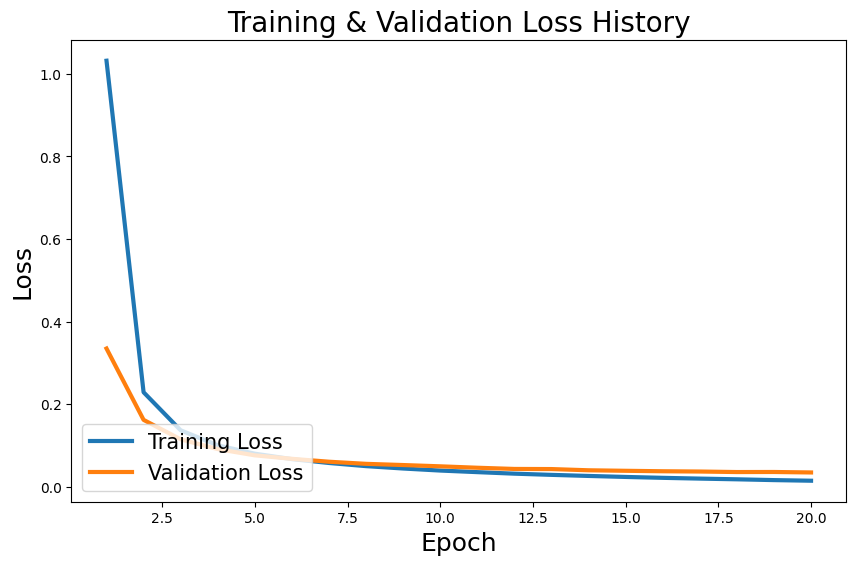

In [14]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Training Loss', linewidth=3)
plt.plot(range(1, len(valid_loss_history) + 1), valid_loss_history, label='Validation Loss', linewidth=3)

plt.title('Training & Validation Loss History', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(loc='lower left', fontsize=15)

plt.savefig('figures/mnist_cnn_loss_history.pdf', format='pdf', bbox_inches='tight')

plt.show();

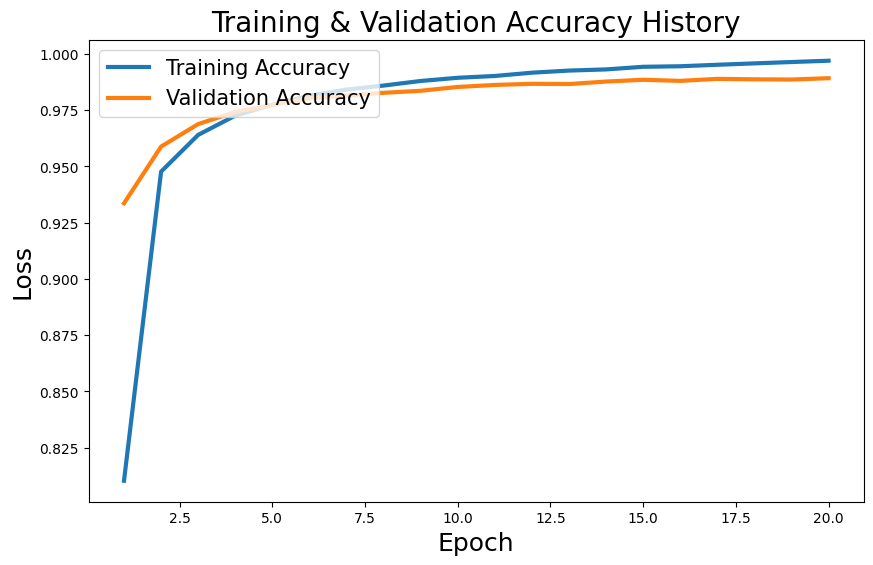

In [15]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_accuracy_history) + 1), train_accuracy_history, label='Training Accuracy', linewidth=3)
plt.plot(range(1, len(valid_accuracy_history) + 1), valid_accuracy_history, label='Validation Accuracy', linewidth=3)

plt.title('Training & Validation Accuracy History', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(loc='upper left', fontsize=15)

plt.savefig('figures/mnist_cnn_accuracy_history.pdf', format='pdf', bbox_inches='tight')

plt.show();

In [16]:
test_loss, test_accuracy = test_model(cnn_model, test_loader, criterion, device='cuda')

Test Loss: 0.0308, Test Accuracy: 0.9900%


## CIFAR-10 Image Classification

In [17]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_set, valid_set = torch.utils.data.random_split(train_dataset, [40000, 10000])
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

#### Linear Neural Network

In [19]:
lnn_model = lnn.LNN(32 * 32 * 3, num_classes=10)

num_params = sum([p.numel() for p in lnn_model.parameters()])
print("Number of parameters: ", num_params)

Number of parameters:  17844234


In [20]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lnn_model.parameters(), lr=0.00001)

train_loss_history, train_accuracy_history, valid_loss_history, valid_accuracy_history = train_model(lnn_model, train_loader, valid_loader, criterion, optimizer, epochs=30, device='cuda', model_name='lnn', dataset_name='cifar')

Epoch 1/30:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1/30: 100%|██████████| 157/157 [00:00<00:00, 249.05it/s]


Train Loss: 1.8924, Train Accuracy: 0.3254
Valid Loss: 1.6666, Valid Accuracy: 0.4081


Epoch 2/30: 100%|██████████| 157/157 [00:00<00:00, 261.25it/s]


Train Loss: 1.6268, Train Accuracy: 0.4208
Valid Loss: 1.5617, Valid Accuracy: 0.4507


Epoch 3/30: 100%|██████████| 157/157 [00:00<00:00, 250.57it/s]


Train Loss: 1.5266, Train Accuracy: 0.4587
Valid Loss: 1.4846, Valid Accuracy: 0.4768


Epoch 4/30: 100%|██████████| 157/157 [00:00<00:00, 259.97it/s]


Train Loss: 1.4494, Train Accuracy: 0.4886
Valid Loss: 1.4455, Valid Accuracy: 0.4875


Epoch 5/30: 100%|██████████| 157/157 [00:00<00:00, 213.73it/s]


Train Loss: 1.3873, Train Accuracy: 0.5109
Valid Loss: 1.4016, Valid Accuracy: 0.5073


Epoch 6/30: 100%|██████████| 157/157 [00:00<00:00, 258.08it/s]


Train Loss: 1.3318, Train Accuracy: 0.5299
Valid Loss: 1.3770, Valid Accuracy: 0.5156


Epoch 7/30: 100%|██████████| 157/157 [00:00<00:00, 253.32it/s]


Train Loss: 1.2818, Train Accuracy: 0.5484
Valid Loss: 1.3628, Valid Accuracy: 0.5195


Epoch 8/30: 100%|██████████| 157/157 [00:00<00:00, 244.74it/s]


Train Loss: 1.2342, Train Accuracy: 0.5641
Valid Loss: 1.3441, Valid Accuracy: 0.5309


Epoch 9/30: 100%|██████████| 157/157 [00:00<00:00, 259.16it/s]


Train Loss: 1.1892, Train Accuracy: 0.5834
Valid Loss: 1.3240, Valid Accuracy: 0.5344


Epoch 10/30: 100%|██████████| 157/157 [00:00<00:00, 265.97it/s]


Train Loss: 1.1450, Train Accuracy: 0.5967
Valid Loss: 1.3265, Valid Accuracy: 0.5336


Epoch 11/30: 100%|██████████| 157/157 [00:00<00:00, 258.06it/s]


Train Loss: 1.1042, Train Accuracy: 0.6110
Valid Loss: 1.3250, Valid Accuracy: 0.5422


Epoch 12/30: 100%|██████████| 157/157 [00:00<00:00, 234.46it/s]


Train Loss: 1.0631, Train Accuracy: 0.6253
Valid Loss: 1.3123, Valid Accuracy: 0.5460


Epoch 13/30: 100%|██████████| 157/157 [00:00<00:00, 267.34it/s]


Train Loss: 1.0216, Train Accuracy: 0.6419
Valid Loss: 1.3203, Valid Accuracy: 0.5479


Epoch 14/30: 100%|██████████| 157/157 [00:00<00:00, 259.33it/s]


Train Loss: 0.9819, Train Accuracy: 0.6566
Valid Loss: 1.3153, Valid Accuracy: 0.5480


Epoch 15/30: 100%|██████████| 157/157 [00:00<00:00, 240.80it/s]


Train Loss: 0.9402, Train Accuracy: 0.6704
Valid Loss: 1.3148, Valid Accuracy: 0.5492


Epoch 16/30: 100%|██████████| 157/157 [00:00<00:00, 255.88it/s]


Train Loss: 0.8999, Train Accuracy: 0.6853
Valid Loss: 1.3248, Valid Accuracy: 0.5505


Epoch 17/30: 100%|██████████| 157/157 [00:00<00:00, 248.49it/s]


Train Loss: 0.8618, Train Accuracy: 0.6977
Valid Loss: 1.3727, Valid Accuracy: 0.5423


Epoch 18/30: 100%|██████████| 157/157 [00:00<00:00, 249.47it/s]


Train Loss: 0.8221, Train Accuracy: 0.7122
Valid Loss: 1.3727, Valid Accuracy: 0.5456


Epoch 19/30: 100%|██████████| 157/157 [00:00<00:00, 266.22it/s]


Train Loss: 0.7832, Train Accuracy: 0.7270
Valid Loss: 1.3844, Valid Accuracy: 0.5506


Epoch 20/30: 100%|██████████| 157/157 [00:00<00:00, 257.16it/s]


Train Loss: 0.7464, Train Accuracy: 0.7389
Valid Loss: 1.3878, Valid Accuracy: 0.5528


Epoch 21/30: 100%|██████████| 157/157 [00:00<00:00, 249.59it/s]


Train Loss: 0.7081, Train Accuracy: 0.7531
Valid Loss: 1.4148, Valid Accuracy: 0.5515


Epoch 22/30: 100%|██████████| 157/157 [00:00<00:00, 248.67it/s]


Train Loss: 0.6703, Train Accuracy: 0.7661
Valid Loss: 1.4474, Valid Accuracy: 0.5548


Epoch 23/30: 100%|██████████| 157/157 [00:00<00:00, 257.69it/s]


Train Loss: 0.6317, Train Accuracy: 0.7806
Valid Loss: 1.4724, Valid Accuracy: 0.5468


Epoch 24/30: 100%|██████████| 157/157 [00:00<00:00, 232.97it/s]


Train Loss: 0.5953, Train Accuracy: 0.7960
Valid Loss: 1.5161, Valid Accuracy: 0.5408


Epoch 25/30: 100%|██████████| 157/157 [00:00<00:00, 254.80it/s]


Train Loss: 0.5633, Train Accuracy: 0.8072
Valid Loss: 1.5235, Valid Accuracy: 0.5468


Epoch 26/30: 100%|██████████| 157/157 [00:00<00:00, 257.84it/s]


Train Loss: 0.5258, Train Accuracy: 0.8219
Valid Loss: 1.6270, Valid Accuracy: 0.5369


Epoch 27/30: 100%|██████████| 157/157 [00:00<00:00, 265.22it/s]


Train Loss: 0.4922, Train Accuracy: 0.8329
Valid Loss: 1.6151, Valid Accuracy: 0.5423


Epoch 28/30: 100%|██████████| 157/157 [00:00<00:00, 261.74it/s]


Train Loss: 0.4607, Train Accuracy: 0.8445
Valid Loss: 1.7004, Valid Accuracy: 0.5359


Epoch 29/30: 100%|██████████| 157/157 [00:00<00:00, 244.48it/s]


Train Loss: 0.4299, Train Accuracy: 0.8556
Valid Loss: 1.7260, Valid Accuracy: 0.5376


Epoch 30/30: 100%|██████████| 157/157 [00:00<00:00, 247.58it/s]


Train Loss: 0.4004, Train Accuracy: 0.8680
Valid Loss: 1.7645, Valid Accuracy: 0.5431
Total training time: 175.87 seconds.
Best model at epoch 22 with valid loss: 1.4474, valid accuracy: 0.5548


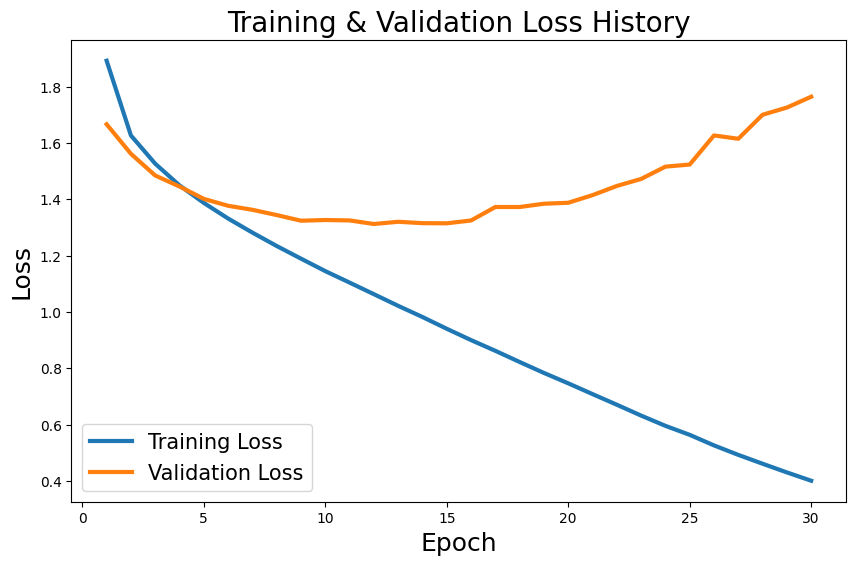

In [21]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Training Loss', linewidth=3)
plt.plot(range(1, len(valid_loss_history) + 1), valid_loss_history, label='Validation Loss', linewidth=3)

plt.title('Training & Validation Loss History', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(loc='lower left', fontsize=15)

plt.savefig('figures/cifar_lnn_loss_history.pdf', format='pdf', bbox_inches='tight')

plt.show();

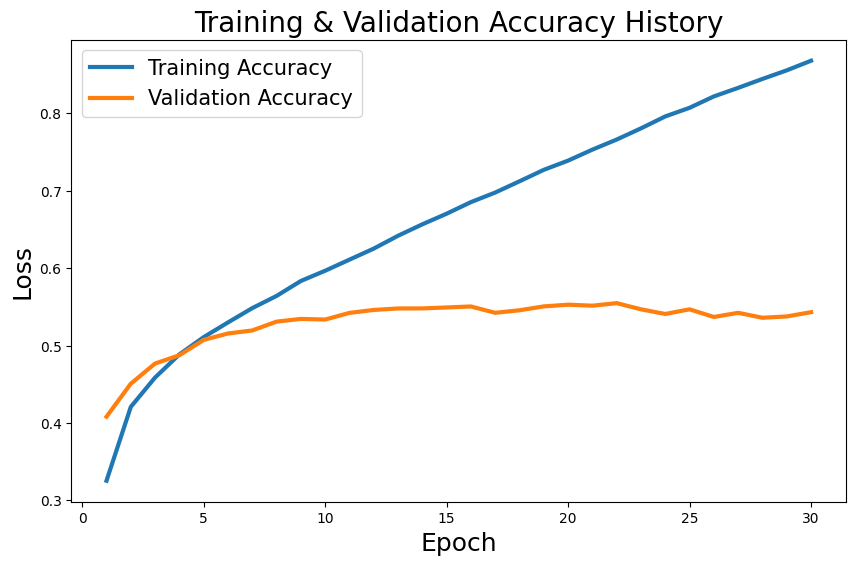

In [22]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_accuracy_history) + 1), train_accuracy_history, label='Training Accuracy', linewidth=3)
plt.plot(range(1, len(valid_accuracy_history) + 1), valid_accuracy_history, label='Validation Accuracy', linewidth=3)

plt.title('Training & Validation Accuracy History', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(loc='upper left', fontsize=15)

plt.savefig('figures/cifar_lnn_accuracy_history.pdf', format='pdf', bbox_inches='tight')

plt.show();

In [23]:
test_loss, test_accuracy = test_model(lnn_model, test_loader, criterion, device='cuda')

Test Loss: 1.8542, Test Accuracy: 0.5238%


#### Convolutional Neural Network

In [24]:
cnn_model = cnn.CNN(3, num_classes=10)

num_params = sum([p.numel() for p in cnn_model.parameters()])
print("Number of parameters: ", num_params)

Number of parameters:  1107538


In [25]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.00001)

train_loss_history, train_accuracy_history, valid_loss_history, valid_accuracy_history = train_model(cnn_model, train_loader, valid_loader, criterion, optimizer, epochs=30, device='cuda', model_name='cnn', dataset_name='cifar')

Epoch 1/30: 100%|██████████| 157/157 [00:00<00:00, 248.92it/s]


Train Loss: 1.9192, Train Accuracy: 0.3232
Valid Loss: 1.6611, Valid Accuracy: 0.4084


Epoch 2/30: 100%|██████████| 157/157 [00:00<00:00, 258.02it/s]


Train Loss: 1.5980, Train Accuracy: 0.4256
Valid Loss: 1.4903, Valid Accuracy: 0.4625


Epoch 3/30: 100%|██████████| 157/157 [00:00<00:00, 254.71it/s]


Train Loss: 1.4678, Train Accuracy: 0.4732
Valid Loss: 1.3905, Valid Accuracy: 0.5025


Epoch 4/30: 100%|██████████| 157/157 [00:00<00:00, 265.45it/s]


Train Loss: 1.3782, Train Accuracy: 0.5074
Valid Loss: 1.3224, Valid Accuracy: 0.5306


Epoch 5/30: 100%|██████████| 157/157 [00:00<00:00, 267.80it/s]


Train Loss: 1.3103, Train Accuracy: 0.5332
Valid Loss: 1.2771, Valid Accuracy: 0.5455


Epoch 6/30: 100%|██████████| 157/157 [00:00<00:00, 271.66it/s]


Train Loss: 1.2581, Train Accuracy: 0.5526
Valid Loss: 1.2307, Valid Accuracy: 0.5617


Epoch 7/30: 100%|██████████| 157/157 [00:00<00:00, 264.22it/s]


Train Loss: 1.2122, Train Accuracy: 0.5705
Valid Loss: 1.1984, Valid Accuracy: 0.5776


Epoch 8/30: 100%|██████████| 157/157 [00:00<00:00, 271.17it/s]


Train Loss: 1.1742, Train Accuracy: 0.5857
Valid Loss: 1.1696, Valid Accuracy: 0.5856


Epoch 9/30: 100%|██████████| 157/157 [00:00<00:00, 243.84it/s]


Train Loss: 1.1394, Train Accuracy: 0.6005
Valid Loss: 1.1455, Valid Accuracy: 0.5961


Epoch 10/30: 100%|██████████| 157/157 [00:00<00:00, 249.11it/s]


Train Loss: 1.1096, Train Accuracy: 0.6105
Valid Loss: 1.1271, Valid Accuracy: 0.6009


Epoch 11/30: 100%|██████████| 157/157 [00:00<00:00, 246.67it/s]


Train Loss: 1.0824, Train Accuracy: 0.6195
Valid Loss: 1.1056, Valid Accuracy: 0.6106


Epoch 12/30: 100%|██████████| 157/157 [00:00<00:00, 237.55it/s]


Train Loss: 1.0577, Train Accuracy: 0.6288
Valid Loss: 1.0935, Valid Accuracy: 0.6126


Epoch 13/30: 100%|██████████| 157/157 [00:00<00:00, 268.26it/s]


Train Loss: 1.0344, Train Accuracy: 0.6374
Valid Loss: 1.0761, Valid Accuracy: 0.6166


Epoch 14/30: 100%|██████████| 157/157 [00:00<00:00, 257.16it/s]


Train Loss: 1.0121, Train Accuracy: 0.6475
Valid Loss: 1.0620, Valid Accuracy: 0.6236


Epoch 15/30: 100%|██████████| 157/157 [00:00<00:00, 259.91it/s]


Train Loss: 0.9933, Train Accuracy: 0.6532
Valid Loss: 1.0533, Valid Accuracy: 0.6232


Epoch 16/30: 100%|██████████| 157/157 [00:00<00:00, 259.31it/s]


Train Loss: 0.9742, Train Accuracy: 0.6613
Valid Loss: 1.0403, Valid Accuracy: 0.6273


Epoch 17/30: 100%|██████████| 157/157 [00:00<00:00, 252.51it/s]


Train Loss: 0.9567, Train Accuracy: 0.6673
Valid Loss: 1.0276, Valid Accuracy: 0.6332


Epoch 18/30: 100%|██████████| 157/157 [00:00<00:00, 268.59it/s]


Train Loss: 0.9402, Train Accuracy: 0.6720
Valid Loss: 1.0227, Valid Accuracy: 0.6356


Epoch 19/30: 100%|██████████| 157/157 [00:00<00:00, 257.33it/s]


Train Loss: 0.9236, Train Accuracy: 0.6796
Valid Loss: 1.0169, Valid Accuracy: 0.6375


Epoch 20/30: 100%|██████████| 157/157 [00:00<00:00, 250.25it/s]


Train Loss: 0.9081, Train Accuracy: 0.6860
Valid Loss: 1.0107, Valid Accuracy: 0.6396


Epoch 21/30: 100%|██████████| 157/157 [00:00<00:00, 259.26it/s]


Train Loss: 0.8929, Train Accuracy: 0.6895
Valid Loss: 0.9998, Valid Accuracy: 0.6444


Epoch 22/30: 100%|██████████| 157/157 [00:00<00:00, 216.07it/s]


Train Loss: 0.8778, Train Accuracy: 0.6951
Valid Loss: 0.9953, Valid Accuracy: 0.6469


Epoch 23/30: 100%|██████████| 157/157 [00:00<00:00, 235.21it/s]


Train Loss: 0.8651, Train Accuracy: 0.7010
Valid Loss: 0.9883, Valid Accuracy: 0.6506


Epoch 24/30: 100%|██████████| 157/157 [00:00<00:00, 239.91it/s]


Train Loss: 0.8498, Train Accuracy: 0.7065
Valid Loss: 0.9811, Valid Accuracy: 0.6494


Epoch 25/30: 100%|██████████| 157/157 [00:00<00:00, 227.48it/s]


Train Loss: 0.8387, Train Accuracy: 0.7105
Valid Loss: 0.9808, Valid Accuracy: 0.6515


Epoch 26/30: 100%|██████████| 157/157 [00:00<00:00, 243.98it/s]


Train Loss: 0.8246, Train Accuracy: 0.7163
Valid Loss: 0.9758, Valid Accuracy: 0.6513


Epoch 27/30: 100%|██████████| 157/157 [00:00<00:00, 203.35it/s]


Train Loss: 0.8116, Train Accuracy: 0.7211
Valid Loss: 0.9683, Valid Accuracy: 0.6541


Epoch 28/30: 100%|██████████| 157/157 [00:00<00:00, 239.54it/s]


Train Loss: 0.8016, Train Accuracy: 0.7218
Valid Loss: 0.9694, Valid Accuracy: 0.6557


Epoch 29/30: 100%|██████████| 157/157 [00:00<00:00, 248.70it/s]


Train Loss: 0.7901, Train Accuracy: 0.7276
Valid Loss: 0.9604, Valid Accuracy: 0.6603


Epoch 30/30: 100%|██████████| 157/157 [00:00<00:00, 255.02it/s]

Train Loss: 0.7759, Train Accuracy: 0.7340
Valid Loss: 0.9637, Valid Accuracy: 0.6583
Total training time: 116.66 seconds.
Best model at epoch 29 with valid loss: 0.9604, valid accuracy: 0.6603


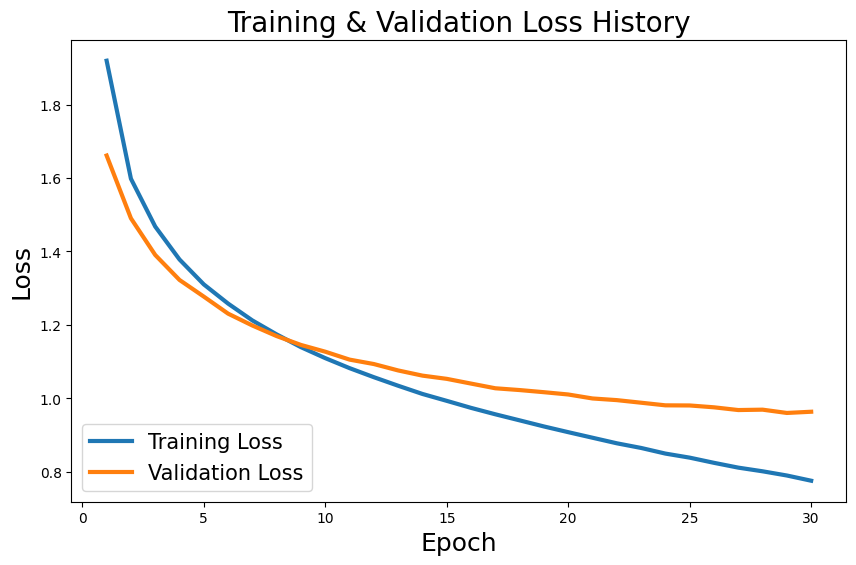

In [26]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Training Loss', linewidth=3)
plt.plot(range(1, len(valid_loss_history) + 1), valid_loss_history, label='Validation Loss', linewidth=3)

plt.title('Training & Validation Loss History', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(loc='lower left', fontsize=15)

plt.savefig('figures/cifar_cnn_loss_history.pdf', format='pdf', bbox_inches='tight')

plt.show();

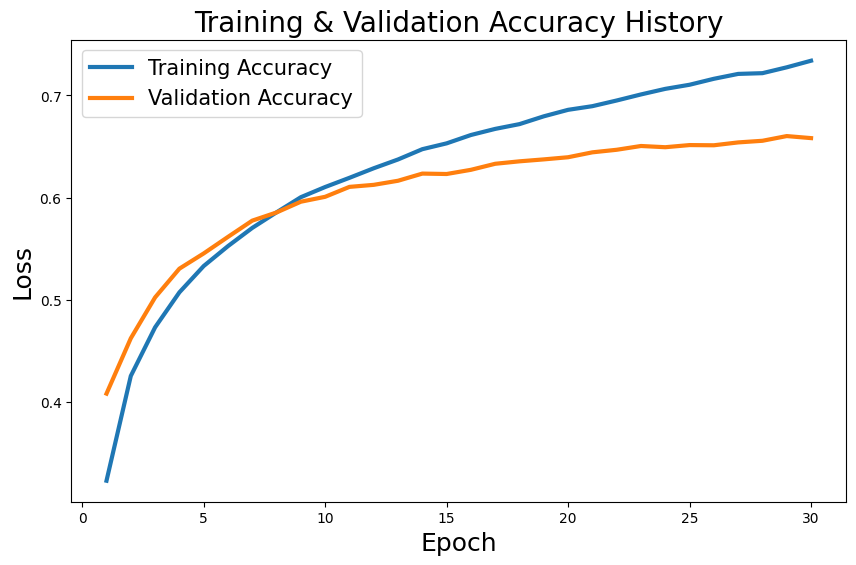

In [27]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_accuracy_history) + 1), train_accuracy_history, label='Training Accuracy', linewidth=3)
plt.plot(range(1, len(valid_accuracy_history) + 1), valid_accuracy_history, label='Validation Accuracy', linewidth=3)

plt.title('Training & Validation Accuracy History', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(loc='upper left', fontsize=15)

plt.savefig('figures/cifar_cnn_accuracy_history.pdf', format='pdf', bbox_inches='tight')

plt.show();

In [28]:
test_loss, test_accuracy = test_model(cnn_model, test_loader, criterion, device='cuda')

Test Loss: 0.9839, Test Accuracy: 0.6526%


### Residual Network

In [42]:
resnet_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [43]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=resnet_transform)
train_set, valid_set = torch.utils.data.random_split(train_dataset, [40000, 10000])
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=resnet_transform)

Files already downloaded and verified
Files already downloaded and verified


In [44]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

In [45]:
resnet_model = resnet.ResNet(num_classes=10, pretrained=True)

num_params = sum([p.numel() for p in resnet_model.parameters()])
print("Number of parameters: ", num_params)

Number of parameters:  11181642


In [46]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.00001)

train_loss_history, train_accuracy_history, valid_loss_history, valid_accuracy_history = train_model(resnet_model, train_loader, valid_loader, criterion, optimizer, epochs=10, device='cuda', model_name='resnet', dataset_name='cifar')

Epoch 1/10: 100%|██████████| 157/157 [00:07<00:00, 22.04it/s]


Train Loss: 0.8870, Train Accuracy: 0.7375
Valid Loss: 0.4119, Valid Accuracy: 0.8781


Epoch 2/10: 100%|██████████| 157/157 [00:07<00:00, 22.29it/s]


Train Loss: 0.3327, Train Accuracy: 0.8993
Valid Loss: 0.2681, Valid Accuracy: 0.9198


Epoch 3/10: 100%|██████████| 157/157 [00:07<00:00, 21.77it/s]


Train Loss: 0.2162, Train Accuracy: 0.9363
Valid Loss: 0.2246, Valid Accuracy: 0.9297


Epoch 4/10: 100%|██████████| 157/157 [00:07<00:00, 21.76it/s]


Train Loss: 0.1506, Train Accuracy: 0.9580
Valid Loss: 0.1985, Valid Accuracy: 0.9359


Epoch 5/10: 100%|██████████| 157/157 [00:06<00:00, 24.75it/s]


Train Loss: 0.1028, Train Accuracy: 0.9741
Valid Loss: 0.1880, Valid Accuracy: 0.9387


Epoch 6/10: 100%|██████████| 157/157 [00:06<00:00, 24.69it/s]


Train Loss: 0.0713, Train Accuracy: 0.9854
Valid Loss: 0.1800, Valid Accuracy: 0.9416


Epoch 7/10: 100%|██████████| 157/157 [00:06<00:00, 24.58it/s]


Train Loss: 0.0472, Train Accuracy: 0.9927
Valid Loss: 0.1798, Valid Accuracy: 0.9404


Epoch 8/10: 100%|██████████| 157/157 [00:06<00:00, 24.56it/s]


Train Loss: 0.0305, Train Accuracy: 0.9973
Valid Loss: 0.1795, Valid Accuracy: 0.9402


Epoch 9/10: 100%|██████████| 157/157 [00:06<00:00, 24.71it/s]


Train Loss: 0.0211, Train Accuracy: 0.9983
Valid Loss: 0.1817, Valid Accuracy: 0.9420


Epoch 10/10: 100%|██████████| 157/157 [00:06<00:00, 24.68it/s]


Train Loss: 0.0142, Train Accuracy: 0.9994
Valid Loss: 0.1817, Valid Accuracy: 0.9418
Total training time: 736.33 seconds.
Best model at epoch 9 with valid loss: 0.1817, valid accuracy: 0.9420


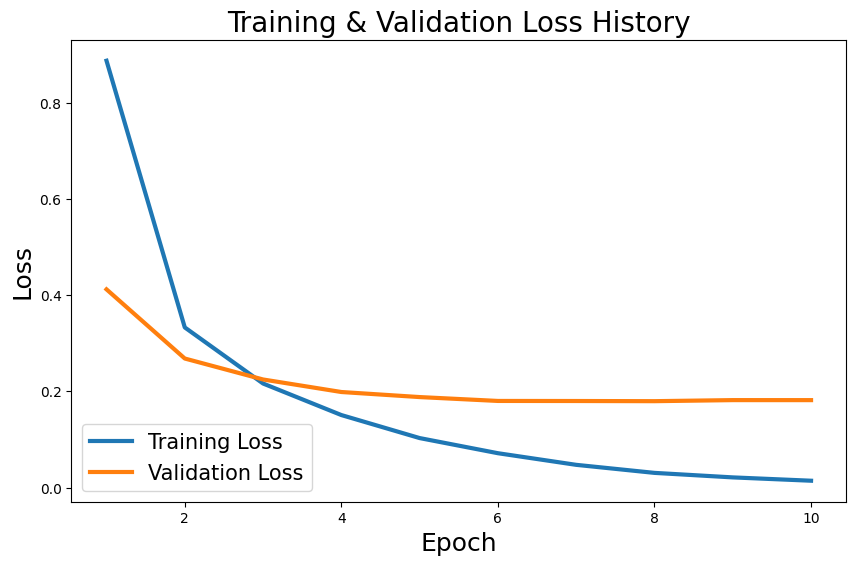

In [47]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Training Loss', linewidth=3)
plt.plot(range(1, len(valid_loss_history) + 1), valid_loss_history, label='Validation Loss', linewidth=3)

plt.title('Training & Validation Loss History', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(loc='lower left', fontsize=15)

plt.savefig('figures/cifar_resnet_loss_history.pdf', format='pdf', bbox_inches='tight')

plt.show();

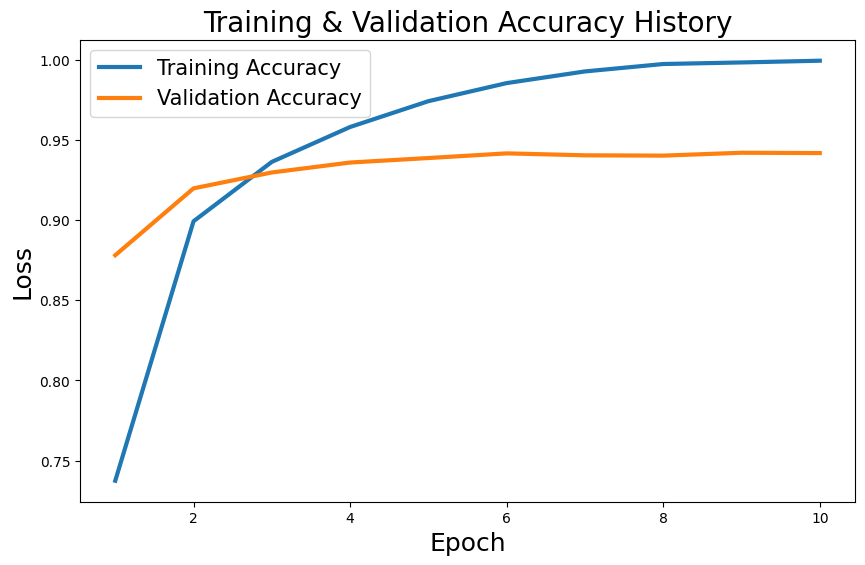

In [48]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_accuracy_history) + 1), train_accuracy_history, label='Training Accuracy', linewidth=3)
plt.plot(range(1, len(valid_accuracy_history) + 1), valid_accuracy_history, label='Validation Accuracy', linewidth=3)

plt.title('Training & Validation Accuracy History', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(loc='upper left', fontsize=15)

plt.savefig('figures/cifar_resnet_accuracy_history.pdf', format='pdf', bbox_inches='tight')

plt.show();

In [49]:
test_loss, test_accuracy = test_model(resnet_model, test_loader, criterion, device='cuda')

Test Loss: 0.2107, Test Accuracy: 0.9357%
